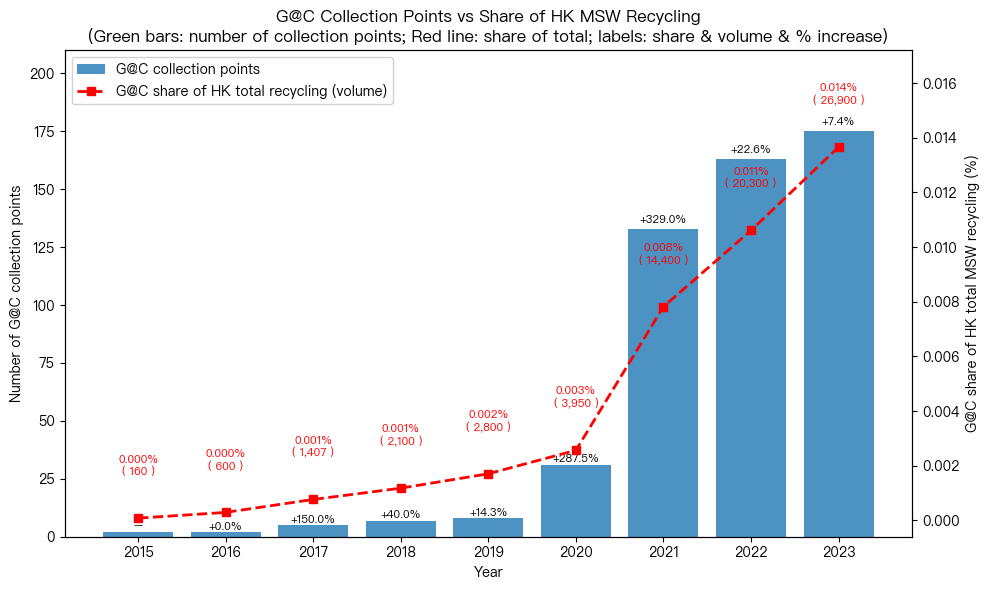

In [32]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys

def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("numpy")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- load data ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- select & clean the needed columns ----------
col_points = "Number of G@C collection points"
col_share = "G@C share of HK total MSW recycling"
col_volume = "G@C recyclables collection volume (tonnes)"

# Keep only rows where all three are present (this also drops the blank rows at the top)
mask = df[col_points].notna() & df[col_share].notna() & df[col_volume].notna()
sub = df.loc[mask, [col_points, col_share, col_volume]].copy()

# Convert to numeric
sub[col_points] = pd.to_numeric(sub[col_points], errors="coerce")
sub[col_volume] = pd.to_numeric(
    sub[col_volume].astype(str).str.replace(",", ""), errors="coerce"
)

# Convert share from "0.01%" strings to percentage numbers (0.01 -> 0.01)
sub["share_pct"] = (
    sub[col_share].astype(str).str.rstrip("%").replace("", np.nan).astype(float)
)

# Percentage increase in number of collection points (year-on-year)
sub["points_pct_change"] = sub[col_points].pct_change() * 100

# X-axis labels: use Year if available, otherwise index (1, 2, 3, ...)
if "Year" in df.columns:
    sub["Year"] = df.loc[sub.index, "Year"].astype(int).astype(str)
    x_labels = sub["Year"].tolist()
else:
    x_labels = [str(i + 1) for i in range(len(sub))]

x = np.arange(len(sub))

# ---------- plotting ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: number of collection points (green)
bars = ax1.bar(x, sub[col_points], alpha=0.8, label="G@C collection points")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of G@C collection points", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=0)

# Add some extra space at the top for bar labels
y1_max = sub[col_points].max()
ax1.set_ylim(0, y1_max * 1.2)

# Label bars with percentage increase
for bar, pct in zip(bars, sub["points_pct_change"]):
    height = bar.get_height()
    if np.isnan(pct):
        label = "–"
    else:
        label = f"{pct:+.1f}%"
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height * 1.01,
        label,
        ha="center",
        va="bottom",
        fontsize=8,
    )

# Second y-axis for G@C share of total MSW (red line, in %)
ax2 = ax1.twinx()
line, = ax2.plot(
    x,
    sub["share_pct"],
    color="red",
    marker="s",
    linewidth=2,
    linestyle="--",
    label="G@C share of HK total recycling (volume)"
)
ax2.set_ylabel("G@C share of HK total MSW recycling (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Add some extra space at the top for line labels
y2_min, y2_max = ax2.get_ylim()
ax2.set_ylim(y2_min, y2_max * 1.2)

# Compute a vertical offset for the line labels so they don't sit on the red dots
label_offset = (y2_max - y2_min) * 0.10  # space for two text lines

# Label line points with share (%) and recycling volume
for xi, yi, share, vol in zip(x, sub["share_pct"], sub["share_pct"], sub[col_volume]):
    ax2.text(
        xi,
        yi + label_offset,
        f"{share:.3f}%\n( {vol:,.0f} )",
        ha="center",
        va="bottom",
        fontsize=8,
        color="red",
    )

# Legend (board) on top-left
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="upper left",
    frameon=True,
    fancybox=True,
    framealpha=0.9,
)

# Title and layout
plt.title(
    "G@C Collection Points vs Share of HK MSW Recycling\n"
    "(Green bars: number of collection points; Red line: share of total; "
    "labels: share & volume & % increase)"
)

fig.tight_layout()
plt.show()
